# ASTRO534 Project 1 
**Using Ultra-Compact Radio Sources to Find the Turnover Point of Angular-Diameter Distance**

Author: Zihao Zuo

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import re
import numpy as np
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel, RBF
from scipy.integrate import quad
from astropy import units as u 
from astropy import constants as const

#Change direction to local style file
plt.style.use('/Users/zuo/Documents/Courses/ASTRO534/mplstyle.txt')

## Introduction

Understanding the expansion history and geometric structure of the universe is a fundamental goal of modern cosmology. One of the unique observational tools available for this purpose is the angular-diameter distance  $d_A(z)$, which exhibits a maximum at a redshift $z_{\max}$ before decreasing as the universe expands. 

Recent studies have demonstrated that compact structures in ultra-luminous quasars can serve as standard rulers in the universe. These quasars, observed at radio frequencies through very-long-baseline interferometry (VLBI), have been shown to exhibit negligible redshift evolution when selected carefully within an intermediate-luminosity range, making them robust tools for measuring $d_A(z)$ (Cao et al. 2017). 

Since $d_A(z)$ has a one-to-one relation with the angular diameter $\theta(z)$ for objects with fixed physical sizes, studying the trend of $d_A(z)$ is equivalent to studying that of $\theta(z)$. In this project, the relation between $\theta$ and redshift is estimated using Gaussian Process Regression (GPR) following Melia & Yennapureddy (2018). By applying this method to a dataset of compact quasar cores, ideally, $z_{\max}$ can be determined and used as a diagnostic for distinguishing between competing cosmological models. Furthermore, a Monte Carlo Markov Chain (MCMC) sampling approach is implemented to quantify the uncertainty in $z_{\max}$. 



## Sample Selection

The sample used in this project was selected by Cao et al. (2017). It contains 120 ultra-compact radio quasars spanning a redshift range of $0.46 < z < 2.76$. The data set is based on a VLBI survey conducted by Preston et al. (1985), which detected 917 compact radio sources with milliarcsecond-scale angular size measurements. These high-resolution observations provided a foundation for identifying quasars with well-defined core structures that could be used to probe the angular diameter distance-redshift relation.

To refine the sample, Cao et al. (2017) applied specific selection criteria to exclude sources with structural complexity or intrinsic evolution that could introduce biases. The first selection criterion was based on the radio spectral index ($\alpha$), where only quasars with flat spectra in the range $-0.38 \leq \alpha \leq 0.18$ were included. This effectively avoided quasars with steep spectra, which are likely to be affected by extended jet structures or environmental interactions that could alter their observed angular sizes (Kellermann 1993).

Additionally, a luminosity constraint was applied to select quasars within the intermediate-luminosity range of $10^{27} \text{ W/Hz} < L < 10^{28} \text{ W/Hz}$. Previous studies showed that intermediate-luminosity quasars exhibit minimal redshift-dependent evolution in their intrinsic linear size $l_m$, making them more reliable as standard rulers (Cao et al. 2015, 2017). Let $l_m$ be the size of the compact radio core, and use parametrization $l_m = l_0 L^\gamma (1+z)^n$. Intermediate-luminosity quasars have $\gamma\approx 1e-4$, $n\approx 1e-3$). By limiting the sample to sources within this luminosity range, the analysis avoided potential biases introduced by strong luminosity evolution effects.

A further selection step involved excluding quasars with extended radio structures or complex morphology, which could contaminate the angular size measurements. Cao et al. (2017) focused on core-dominated compact quasars, ensuring that the measured angular sizes were primarily determined by the intrinsic jet properties.

After applying these selection criteria, Cao et al. (2017) compiled a final sample of 120 quasars. They determined the intrinsic size of the radio cores of these intermediate-luminosity quasars to be $l_m = 11.03\pm0.25$ pc. The angular size $\theta(z)$ and the angular diameter distance $d_A(z)$ is then related by $$\theta(z) = l_m / d_A(z).$$


In [3]:
file_path = "proj1_data.txt"

data = []
with open(file_path, "r", encoding="utf-8") as file:
    lines = file.readlines()

columns = lines[0].strip().split()

for line in lines[1:]:
    match = re.match(r"([A-Za-z0-9+.\- ]+)\s+([\d.]+)\s+(.+)\s+([A-Za-z]+)", line.strip())
    if match:
        source = match.group(1).strip() 
        z = float(match.group(2))  
        numerical_values = match.group(3).split()  
        type_label = match.group(4).strip()  
        cleaned_values = [float(val.replace("−", "-")) for val in numerical_values]
        data.append([source, z] + cleaned_values + [type_label])

df = pd.DataFrame(data, columns=columns)

df = df[df["Type"] == "Q"]
df.info

<bound method DataFrame.info of          Source       z      θ    σ_θ       S    α Type
0    P 2351-006  0.4620  2.743  0.027   2.490 -0.1    Q
1        3C 279  0.5362  1.454  0.052  11.800  0.1    Q
2    P 0252-549  0.5390  1.049  0.077   1.940  0.1    Q
3     P 1136-13  0.5580  1.974  0.048   3.400 -0.3    Q
4     P 0403-13  0.5740  2.399  0.077   4.000  0.1    Q
..          ...     ...    ...    ...     ...  ...  ...
114  P 0642-349  2.1650  1.097  0.223   1.200  0.1    Q
115  P 1032-199  2.1980  1.434  0.036   1.082  0.1    Q
116  P 2314-409  2.4480  1.676  0.045   0.525 -0.3    Q
117  GC 1337+63  2.5584  1.598  0.323   0.600 -0.2    Q
118  P 0329-255  2.6850  1.506  0.101   0.417 -0.1    Q

[113 rows x 7 columns]>

## Methods and Results

### Gaussian Process Regression (GPR)

Gaussian Process Regression (GPR) is employed to infer the evolution of the apparent angular size of a sample of objects $(\theta)$ with a fixed physical size following Melia & Yennapureddy (2018). The unique strength of GPR is that is does not need an assumed parametric form of $\theta(z)$. 

I will then briefly introduce GPR. Let $\mathbf{y}=\mathbf{f}+\mathbf{\epsilon}$, where $\mathbf{y}$ is the observed data, $\mathbf{f}$ is the estimation of the quantity of interest, and $\mathbf{\epsilon}$ is the noise. Here, assume $\mathbf{\epsilon}$ is independently and identically distributed (i.i.d.) and $\epsilon\sim N(0,\sigma_y^2\mathbf{I})$. Also assume that the joint distribution of random variables $f(x_1),\cdots,f(x_n)$ follows a multivariate normal distribution:
$$ p(\mathbf{f}|\mathbf{X})\sim N(\mathbf{f}|\mathbf{\mu,K}) $$
where $\mathbf{\mu} = \mathbf{0}$ and the covariance matrix $\mathbf{K}$ has $K_{ij}=k(x_i,x_j)$. The exact form of $k(x_i,x_j)$ depends on the choice of kernel. Given some new observation(s) $\mathbf{y^*}$, it can be shown that the posterior can be represented as:
$$ p(\mathbf{f^*|X^*,X,f})\sim N(\mathbf{y^*|\mu^*,\Sigma^*}+\sigma_y^2\mathbf{I}) $$
where $\mathbf{\mu^*}=\mathbf{K^{*T} K_y^{-1}f}$ and $\mathbf{\Sigma^*=K^{**}-K^{*T}K_y^{-1}K^*}$. Here, $\mathbf{K^*}=k(\mathbf{X,X^*})$, $\mathbf{K^{**}}=k(\mathbf{X^*,X^*})$, and $\mathbf{K_y = K}+\sigma_y^2\mathbf{I}$.



The GPR is implemented using the GaussianProcessRegressor tool built in the Python package sklearn. The kernel function used is a Matérn kernel, with an explicit form of
$$
k(x_1, x_2) = \sigma_f^2 \exp \left( -\frac{3 |x_1 - x_2|}{l} \right) 
\left( 1 + \frac{3 |x_1 - x_2|}{l} + \frac{27 |x_1 - x_2|^2}{7 l^2} 
+ \frac{18 |x_1 - x_2|^3}{7 l^3} + \frac{27 |x_1 - x_2|^4}{35 l^4} \right)
$$
The hyperparameters $l$ and $\sigma_f$ quantify the bumpiness of the function. A WhiteKernel component has been added to incorporate noise.

The detailed implementation of GPR is shown below. The estimation (blue line) and its error (shaded region) of $\theta(z)$ is plotted in Fig. 1.


(The description of GPR follows https://medium.com/data-science-at-microsoft/introduction-to-gaussian-process-regression-part-1-the-basics-3cb79d9f155f)


/usr/local/anaconda/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


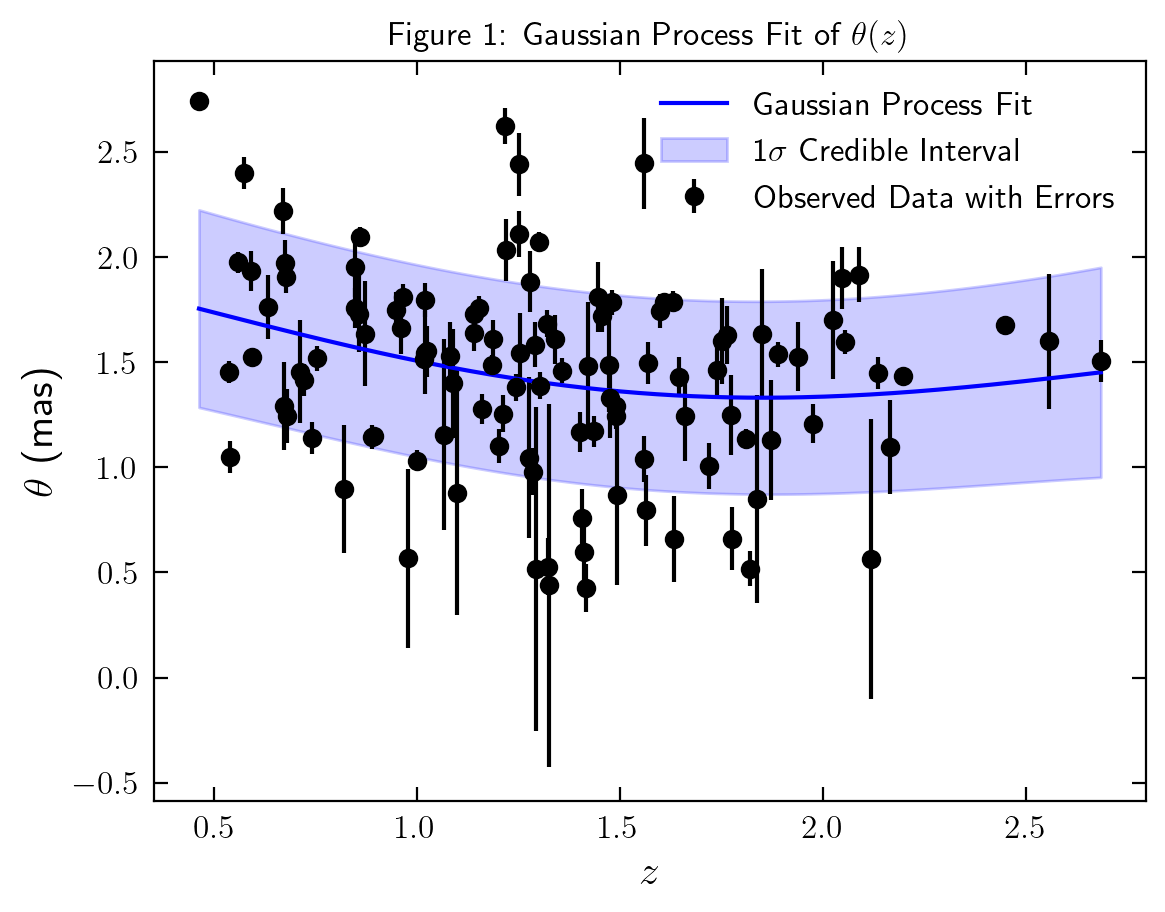

In [10]:
z = df["z"].values.reshape(-1, 1)  
theta = df["θ"].values  
theta_err = df["σ_θ"].values  

kernel = C(1.0, (1e-1, 1e1)) * Matern(length_scale=0.1, nu=5) + WhiteKernel(noise_level=theta_err.mean()**2)

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30)
gpr.fit(z, theta)

z_pred = np.linspace(min(z), max(z), 200).reshape(-1, 1)
theta_pred, sigma_pred = gpr.predict(z_pred, return_std=True)

plt.errorbar(z, theta, yerr=theta_err, fmt='o', color="black", label="Observed Data with Errors")
plt.plot(z_pred, theta_pred, color="blue", label="Gaussian Process Fit")
plt.fill_between(z_pred.ravel(), theta_pred - sigma_pred, theta_pred + sigma_pred, color="blue", alpha=0.2, label=r"1$\sigma$ Credible Interval")
plt.xlabel(r"$z$")
plt.ylabel(r"$\theta$ (mas)")
plt.legend()
plt.title(r"Figure 1: Gaussian Process Fit of $\theta(z)$")
plt.show()



I then tried the RBF kernel, which has a form of 
$$
k(x_1, x_2) = \exp \left( -\frac{d(x_1, x_2)^2}{2 l^2} \right)
$$
But the RBF kernel returns a regression without a turnover in $\theta(z)$. This warns us that the result obtained above might be kernel sensitive and/or the scattering of the data is too large. 

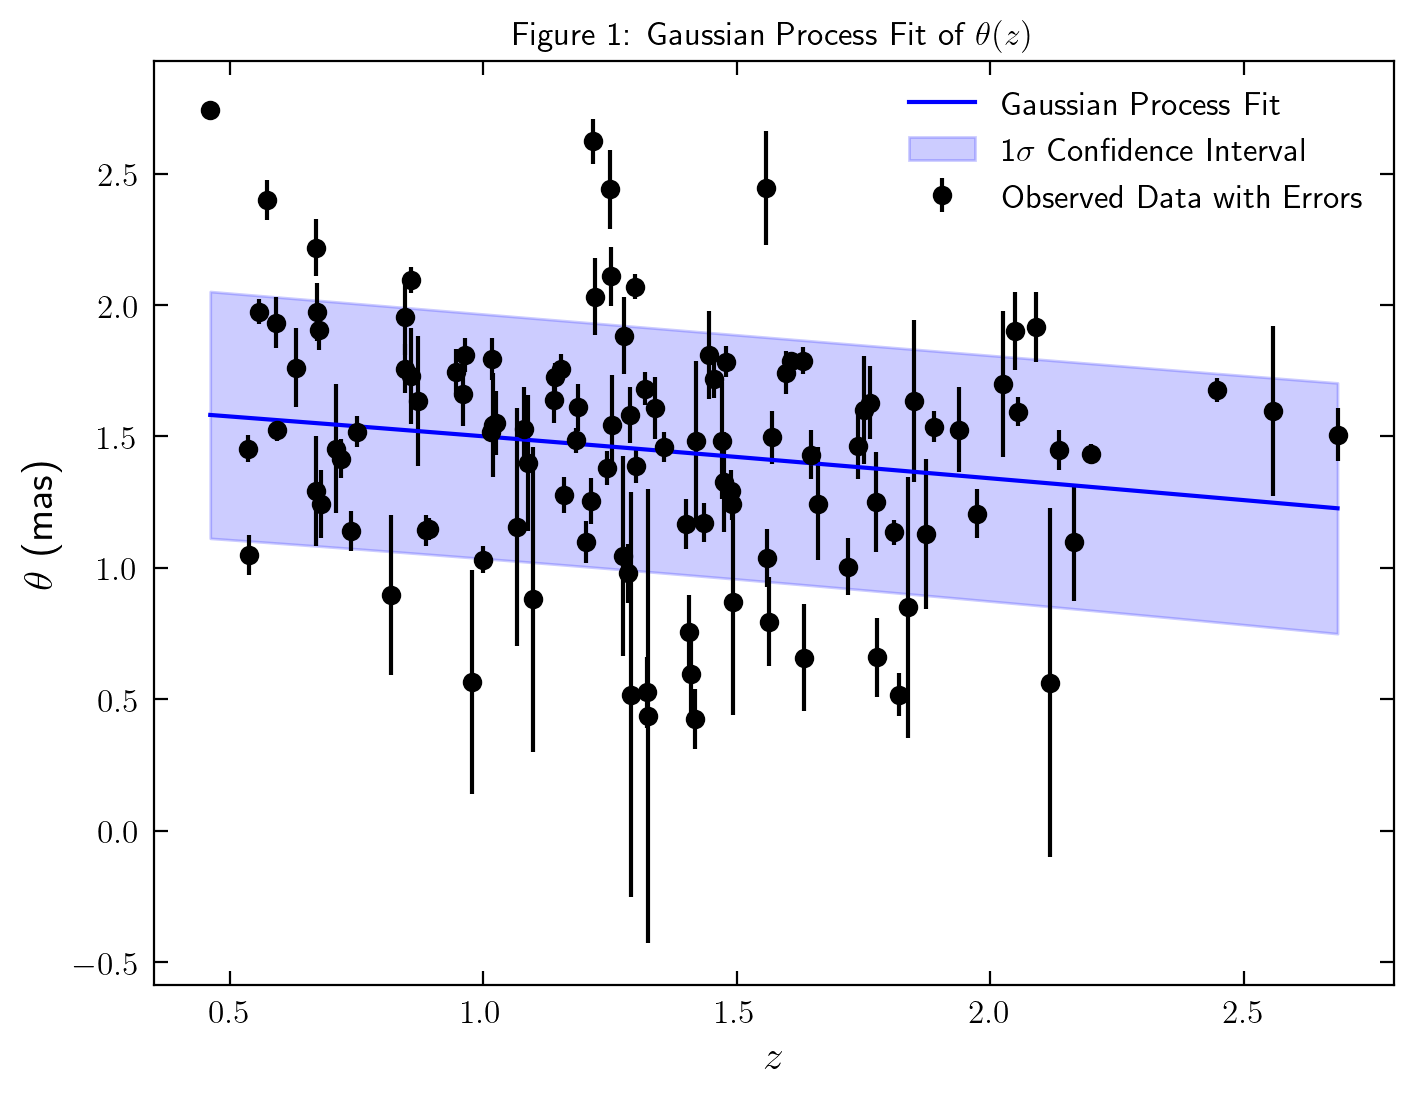

In [6]:
kernel = C(1.0, (1e-1, 1e1)) * RBF(length_scale=1) + WhiteKernel(noise_level=theta_err.mean()**2)

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30)
gpr.fit(z, theta)

z_pred2 = np.linspace(min(z), max(z), 200).reshape(-1, 1)
theta_pred2, sigma_pred2 = gpr.predict(z_pred, return_std=True)

plt.figure(figsize=(8, 6))
plt.errorbar(z, theta, yerr=theta_err, fmt='o', color="black", label="Observed Data with Errors")
plt.plot(z_pred2, theta_pred2, color="blue", label="Gaussian Process Fit")
plt.fill_between(z_pred2.ravel(), theta_pred2 - sigma_pred2, theta_pred2 + sigma_pred2, color="blue", alpha=0.2, label=r"1$\sigma$ Confidence Interval")
plt.xlabel(r"$z$")
plt.ylabel(r"$\theta$ (mas)")
plt.legend()
plt.title(r"Figure 1: Gaussian Process Fit of $\theta(z)$")
plt.show()


### Use Monte Carlo Markov Chain (MCMC)  to estimate $z_{\max}$

A Monte Carlo Markov Chain (MCMC) sampling is then implemented to determine $z_{\max}$. To implement this, 50000 samples are randomly drawn from the posterior distribution of $\theta(z)$ obtained using GPR (500 of them are plotted in Fig. 3). A distribution of $z_{max}$ is then obtained by finding the redshift at which $\theta(z)$ attains a minimum value. The distribution of $z_{max}$ is plotted in Figure 2. The resulting estimation is $z_{\max}=1.88^{+0.54}_{-0.58}$. It is consistent with Melia&Yennapureddy(2018), which gives $z=1.70\pm0.20$.


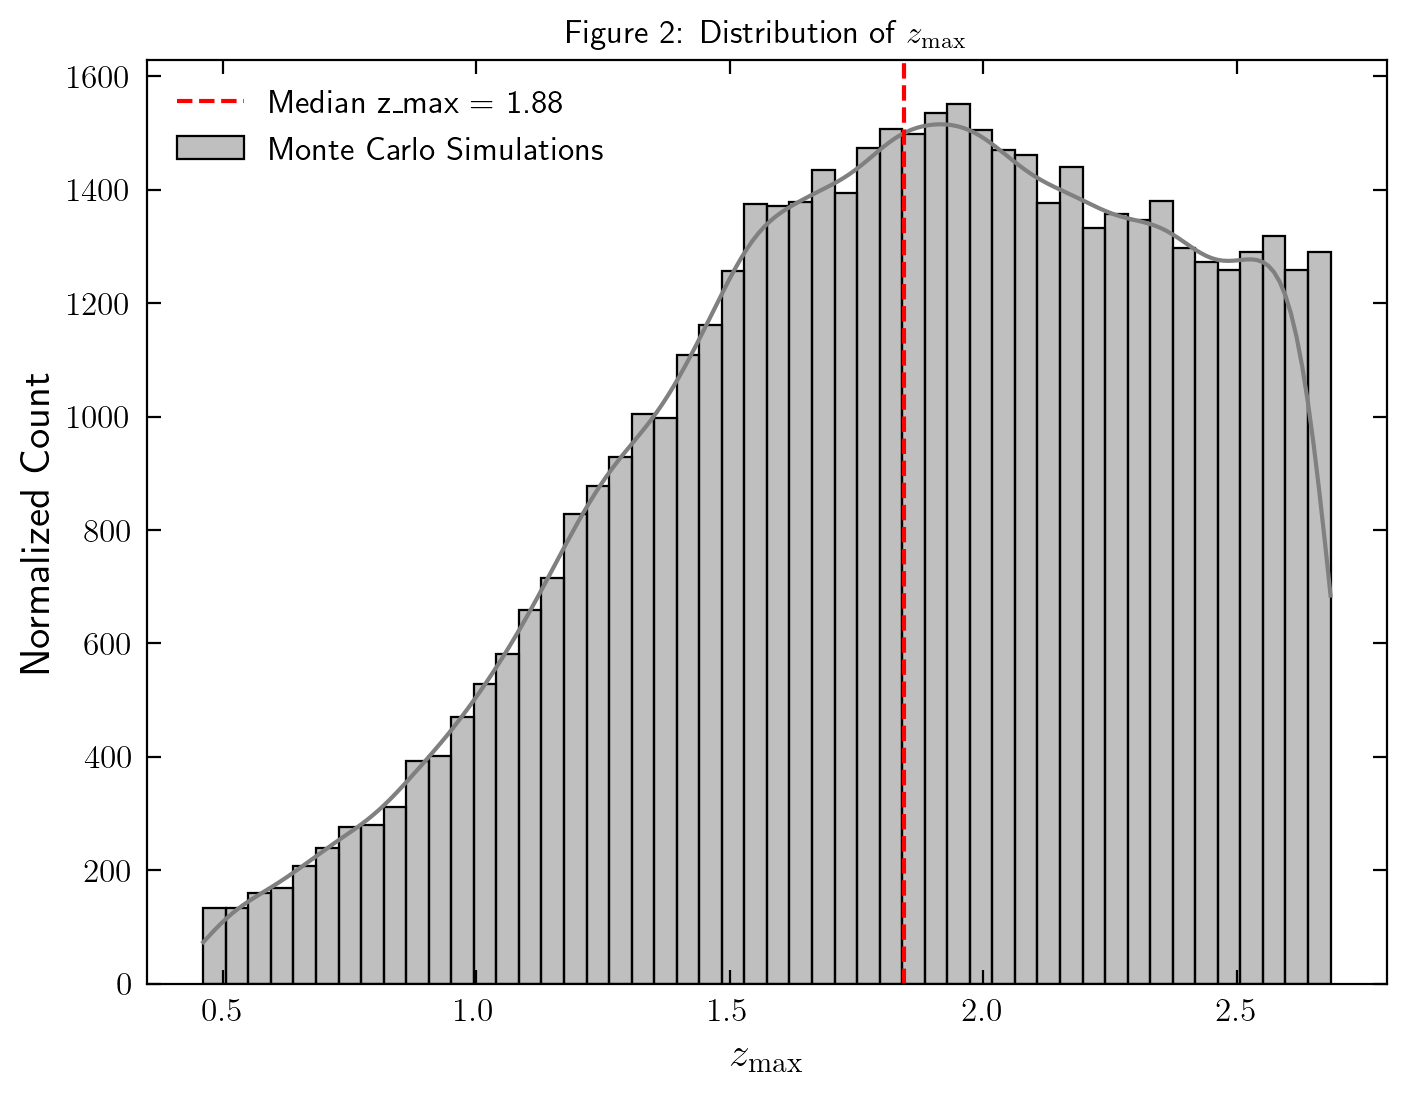

The 16th and 84th percentiles of the z_max distribution are: 1.288643216080402 2.4057286432160803


In [11]:
num_samples = 50000 

theta_samples = np.random.normal(
    loc=theta_pred[:,None], 
    scale=sigma_pred[:,None],  
    size=(200,num_samples)
)

z_max_samples = z_pred[np.argmin(theta_samples, axis=0)].flatten()

plt.figure(figsize=(8, 6))
sns.histplot(z_max_samples, bins=50, kde=True, color="gray", label="Monte Carlo Simulations")
plt.axvline(np.mean(z_max_samples), color="red", linestyle="dashed", label=f"Median z_max = {np.median(z_max_samples):.2f}")
plt.xlabel(r"$z_{\max}$")
plt.ylabel("Normalized Count")
plt.legend()
plt.title(r"Figure 2: Distribution of $z_{\max}$")
plt.show()
print("The 16th and 84th percentiles of the z_max distribution are:", np.percentile(z_max_samples,16),np.percentile(z_max_samples,84))

A sanity check is then conducted to make sure the samples drawn follow the given distribution. In the following figure, the fuzzy lines are samples (500 samples of the total 50000 samples) drawn from the posterior distribution. The blue solid line and the band represent the estimation of $\theta(z)$ and its error bar obtained using GPR.

Text(0.5, 0, 'z')

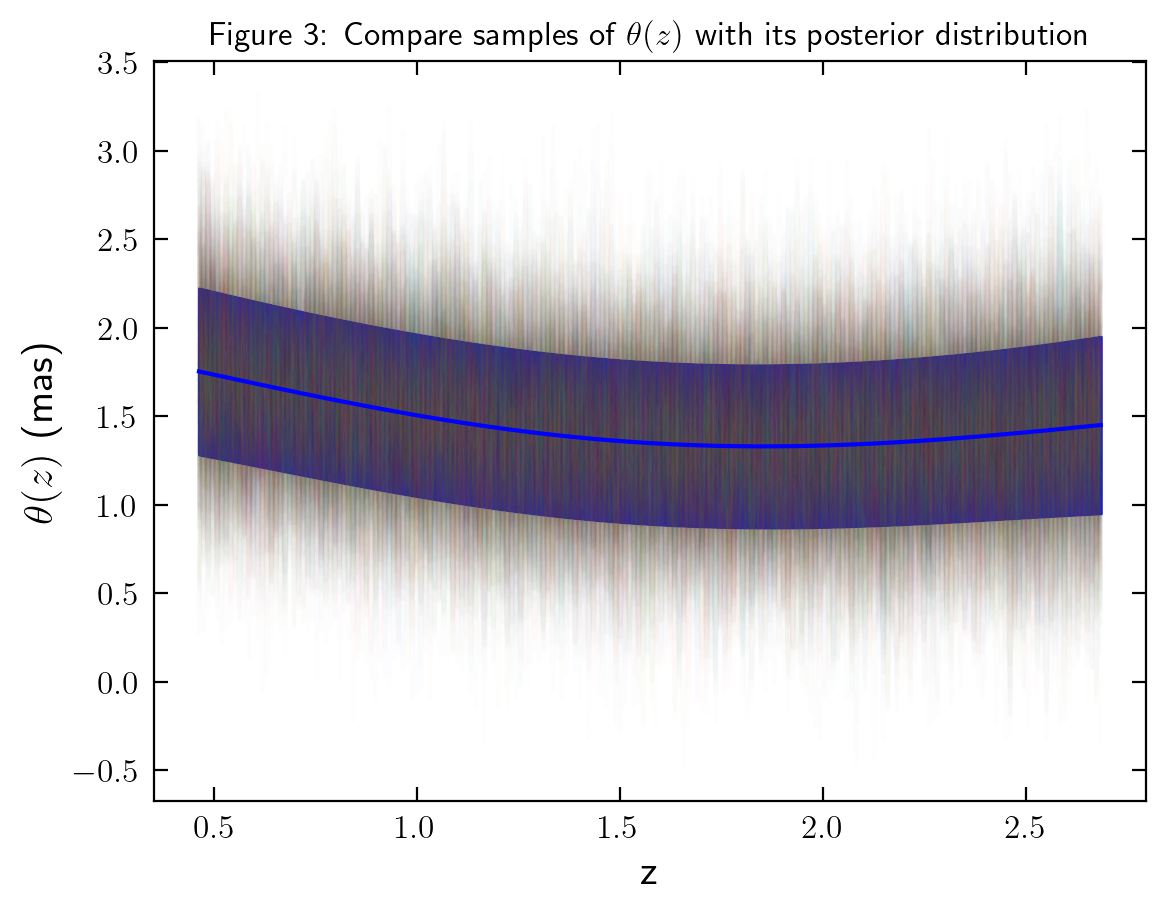

In [12]:
plt.plot(z_pred,theta_samples[:,1000:1500],alpha=0.01)
plt.plot(z_pred, theta_pred, color="blue", label="Gaussian Process Fit")
plt.fill_between(z_pred.ravel(), theta_pred - sigma_pred, theta_pred + sigma_pred, color="blue", alpha=1, label="1σ Confidence Interval")
plt.title(r"Figure 3: Compare samples of $\theta(z)$ with its posterior distribution ")
plt.ylabel(r"$\theta(z)$ (mas)")
plt.xlabel(r"z")

## Discussion

The angular-diameter evolution under the $\Lambda$CDM model is
$$ d_{A,\Lambda CDM}(z) = \frac{c}{H_0} \frac{1}{1+z} \int_0^z \frac{du}{\sqrt{\Omega_m (1 + u)^3 + \Omega_\Lambda (1 + u)^{3(1+w_\Lambda)}}}.
 $$
The expected angular size of radio cores is $\theta(z)_{\Lambda CDM} =l_m / d_{A,\Lambda CDM}(z)$. Take $w_\Lambda=-1$, $\Omega_m = 0.321$, $\Omega_\Lambda = 1 - \Omega_m$, and $H_0 = 66.88$ km s $^{-1}$ Mpc $^{-1}$. The expected angular size of radio cores under the $\Lambda$CDM model is plotted in Fig. 4 as a red line. For comparison, my estimation of $\theta(z)$ based on observed data is also plotted. The estimation of this project agrees with the $\Lambda$CDM model.

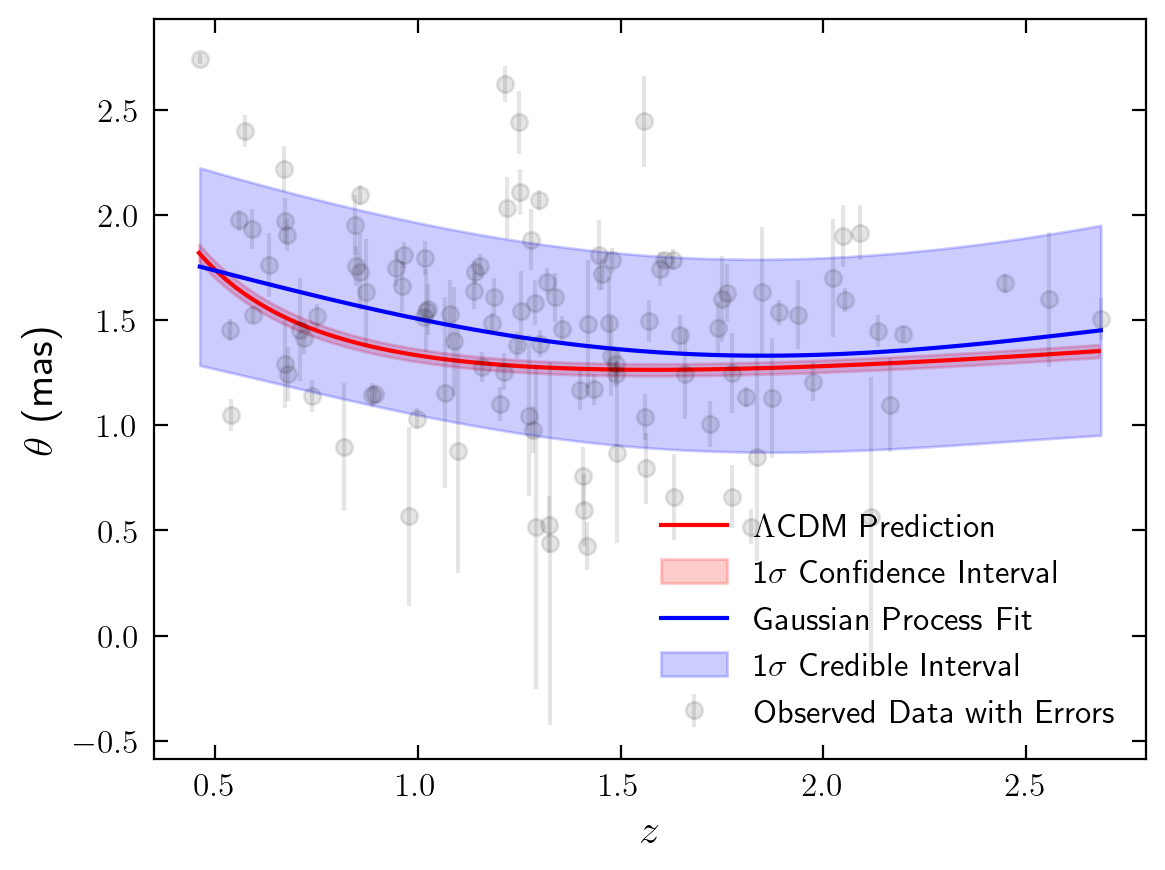

In [29]:
H0 = 66.88 * u.km/u.s/u.Mpc  
c = const.c  
Omega_m = 0.321 
Omega_Lambda = 1- Omega_m  
w_Lambda = -1  

def integrand(u, Omega_m, Omega_Lambda, w_Lambda):
    return 1.0 / np.sqrt(Omega_m * (1 + u)**3 + Omega_Lambda * (1 + u)**(3 * (1 + w_Lambda)))

def dA(z, H0, c, Omega_m, Omega_Lambda, w_Lambda):
    integral, _ = quad(integrand, 0, z, args=(Omega_m, Omega_Lambda, w_Lambda))
    return (c / H0) * (1 / (1 + z)) * integral

z_values = np.linspace(0.46, 2.68, 100)  
dA_values = np.array([(dA(z, H0, c, Omega_m, Omega_Lambda, w_Lambda).to(u.Mpc)).value for z in z_values])
theta_values = (11.03*u.pc/(dA_values*u.Mpc)*u.rad).to(u.mas)

theta_values = (11.03*u.pc/(dA_values*u.Mpc)*u.rad).to(u.mas)
theta_values_hi = (((11.03+0.25)*u.pc/(dA_values*u.Mpc)*u.rad).to(u.mas)).value
theta_values_lo = (((11.03-0.25)*u.pc/(dA_values*u.Mpc)*u.rad).to(u.mas)).value

plt.plot(z_values,theta_values,color="red",label = r"$\Lambda$CDM Prediction")
plt.fill_between(z_values, theta_values_lo, theta_values_hi, color="red", alpha=0.2, label=r"1$\sigma$ Confidence Interval")

plt.errorbar(z, theta, yerr=theta_err, fmt='o', color="black", label="Observed Data with Errors",alpha=0.1)
plt.plot(z_pred, theta_pred, color="blue", label="Gaussian Process Fit")
plt.fill_between(z_pred.ravel(), theta_pred - sigma_pred, theta_pred + sigma_pred, color="blue", alpha=0.2, label=r"1$\sigma$ Credible Interval")
plt.xlabel(r"$z$")
plt.ylabel(r"$\theta$ (mas)")
plt.plot()
plt.legend()
plt.savefig('keyplot.pdf')


## Conclusion and Future Work

In this project,
- The angular-size ($\theta$) versus redshift ($z$) relation is estimated for the radio cores of a group of intermediate-luminosity quasars (Fig. 1) using Gaussian Process Regression (GPR).
- Assuming the intrinsic size of these ultra-compact radio sources is independent of redshift and luminosity (within a certain luminosity range), the evolution of angular diameter distance ($d_A$) can be reconstructed. The redshift where $d_A$ reaches its maximum is estimated to be $z_{\max}=1.88^{+0.54}_{-0.58}$. This is consistent with 
- The resulting $\theta(z)$ estimation is consistent with the prediction of $\Lambda$ CDM model (Fig. 4).

In future works,
- The sample size of the ultra-compact radio sources can be increased to better constrain the evolution of $\theta$.
- The scatter of $\theta$ may not be purely Gaussian. More advanced statistical method can be applied to remove this potential risk (e.g. a two point diagnositc method used in Leaf&Melia 2017).

## References

- Cao S., Zheng X., Biesiada M., Qi J., Chen Y., Zhu Z.-H., 2017, A\&A, 606, A15. doi:10.1051/0004-6361/201730551
- Cao S., Biesiada M., Gavazzi R., Pi{\'o}rkowska A., Zhu Z.-H., 2015, ApJ, 806, 185. doi:10.1088/0004-637X/806/2/185
- Preston R.~A., Morabito D.~D., Williams J.~G., Faulkner J., Jauncey D.~L., Nicolson G., 1985, AJ, 90, 1599. doi:10.1086/113869
- Kellermann K.~I., 1993, Natur, 361, 134. doi:10.1038/361134a0
- Melia F., Yennapureddy M.~K., 2018, MNRAS, 480, 2144. doi:10.1093/mnras/sty1962
